In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import v2
# Hyperparameters
batch_size = 128
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 2
hidden_dim = 512

batch_size = 128
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: x.view(-1) - 0.5),
])

# Download and load the training data
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform=transform,
)
# Download and load the test data
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform,
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [2]:
# load x from the train_loader
x, _ = next(iter(train_loader))
# x is a batch of images, shape: [batch_size, 1, 28, 28]
# Flatten the images to [batch_size, 784]
x = x.view(x.size(0), -1)

x

tensor([[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
        ...,
        [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]])

In [3]:
import matplotlib.pyplot as plt
def show_images(images, labels):
    """
    Display a set of images and their labels using matplotlib.
    The first column of `images` should contain the image indices,
    and the second column should contain the flattened image pixels
    reshaped into 28x28 arrays.
    """
    # Extract the image indices and reshaped pixels
    pixels = images.reshape(-1, 28, 28)

    # Create a figure with subplots for each image
    fig, axs = plt.subplots(
        ncols=len(images), nrows=1, figsize=(10, 3 * len(images))
    )

    # Loop over the images and display them with their labels
    for i in range(len(images)):
        # Display the image and its label
        axs[i].imshow(pixels[i], cmap="gray")
        axs[i].set_title("Label: {}".format(labels[i]))

        # Remove the tick marks and axis labels
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_xlabel("Index: {}".format(i))

    # Adjust the spacing between subplots
    fig.subplots_adjust(hspace=0.5)

    # Show the figure
    plt.show()

In [4]:
# import torch.nn as nn

# class AutoEncoder(nn.Module):
#     def __init__(self, input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim):
#         super().__init__()
        
#         # Set the number of hidden units
#         self.num_hidden = 4
        
#         # Define the encoder part of the autoencoder
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.SiLU(),  # Swish activation function
#             nn.Linear(hidden_dim, hidden_dim // 2),
#             nn.SiLU(),  # Swish activation function
#             nn.Linear(hidden_dim // 2, hidden_dim // 4),
#             nn.SiLU(),  # Swish activation function
#             nn.Linear(hidden_dim // 4, hidden_dim // 8),
#             nn.SiLU(),  # Swish activation function
#             nn.Linear(hidden_dim // 8, hidden_dim//128), # 2 for mean and variance.
#         )
        
#         # Define the decoder part of the autoencoder
#         self.decoder = nn.Sequential(
#             nn.Linear(hidden_dim//128, hidden_dim // 8),
#             nn.SiLU(),  # Swish activation function
#             nn.Linear(hidden_dim // 8, hidden_dim // 4),
#             nn.SiLU(),  # Swish activation function
#             nn.Linear(hidden_dim // 4, hidden_dim // 2),
#             nn.SiLU(),  # Swish activation function
#             nn.Linear(hidden_dim // 2, hidden_dim),
#             nn.SiLU(),  # Swish activation function
#             nn.Linear(hidden_dim, input_dim),
#             nn.Sigmoid(),
#         )

#     def forward(self, x):
#         # Pass the input through the encoder
#         encoded = self.encoder(x)
#         # Pass the encoded representation through the decoder
#         decoded = self.decoder(encoded)
#         # Return both the encoded representation and the reconstructed output
#         return encoded, decoded
import torch.nn as nn
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Set the number of hidden units
        self.num_hidden = 8
        
        # Define the encoder part of the autoencoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),  # input size: 784, output size: 256
            nn.ReLU(),  # apply the ReLU activation function
            nn.Linear(256, self.num_hidden),  # input size: 256, output size: num_hidden
            nn.ReLU(),  # apply the ReLU activation function
        )
        
        # Define the decoder part of the autoencoder
        self.decoder = nn.Sequential(
            nn.Linear(self.num_hidden, 256),  # input size: num_hidden, output size: 256
            nn.ReLU(),  # apply the ReLU activation function
            nn.Linear(256, 784),  # input size: 256, output size: 784
            nn.Sigmoid(),  # apply the sigmoid activation function to compress the output to a range of (0, 1)
        )

    def forward(self, x):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Pass the encoded representation through the decoder
        decoded = self.decoder(encoded)
        # Return both the encoded representation and the reconstructed output
        return encoded, decoded

In [5]:
import torch.optim as optim

learning_rate = 1e-3

# Create the autoencoder model and optimizer
model = AutoEncoder()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.MSELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Set the device to GPU if available, otherwise use CPU
model.to(device)

# # # Create a DataLoader to handle batching of the training data
# train_loader = torch.utils.data.DataLoader(
#     X_train, batch_size=batch_size, shuffle=True
# )

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=8, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [16]:
# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, batch in enumerate(train_loader):
        data = batch[0]  # Get the images from the batch
        # Flatten the images to [batch_size, 784]
        # data = data.view(data.size(0), -1)
        # Convert to float and move to the device
        data = data.to(torch.float32).to(device)

        # Forward pass
        encoded, decoded = model(data)

        # Compute the loss and perform backpropagation
        loss = criterion(decoded, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the running loss
        total_loss += loss.item() * data.size(0)

    # Print the epoch loss
    epoch_loss = total_loss / len(train_loader.dataset)
    print(
        "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
    )

Epoch 1/50: loss=0.2401
Epoch 2/50: loss=0.2313
Epoch 3/50: loss=0.2313
Epoch 4/50: loss=0.2313
Epoch 5/50: loss=0.2313
Epoch 6/50: loss=0.2313
Epoch 7/50: loss=0.2313
Epoch 8/50: loss=0.2313
Epoch 9/50: loss=0.2313
Epoch 10/50: loss=0.2313
Epoch 11/50: loss=0.2313
Epoch 12/50: loss=0.2313
Epoch 13/50: loss=0.2313
Epoch 14/50: loss=0.2313


KeyboardInterrupt: 

In [28]:
# try to show some images input and output
def show_images_input_output(images, labels, outputs):
    """
    Display a set of input images, their labels, and the corresponding output images.
    """
    # Create a figure with subplots for each image
    fig, axs = plt.subplots(
        ncols=2, nrows=len(images), figsize=(10, 3 * len(images))
    )

    # Loop over the images and display them with their labels
    for i in range(len(images)):
        # Display the input image
        axs[i, 0].imshow(images[i].reshape(28, 28), cmap="gray")
        axs[i, 0].set_title("Input: {}".format(labels[i]))
        axs[i, 0].axis('off')

        # Display the output image
        axs[i, 1].imshow(outputs[i].reshape(28, 28), cmap="gray")
        axs[i, 1].set_title("Output: {}".format(labels[i]))
        axs[i, 1].axis('off')


    # Adjust the spacing between subplots
    fig.subplots_adjust(hspace=0.5)

    # Show the figure
    plt.show()

# show_images_input_output(x[5:10], 
#                          [str(i) for i in range(10)], 
#                          model(x[:10].to(device))[1].cpu().detach().numpy())
# show_images_input_output(x[:10], [str(i) for i in range(10)], model(x[:10])[1].detach().numpy())
   

In [6]:
class VAE(AutoEncoder):
    def __init__(self):
        super().__init__()
        # Add mu and log_var layers for reparameterization
        self.mu = nn.Linear(self.num_hidden, self.num_hidden)
        self.log_var = nn.Linear(self.num_hidden, self.num_hidden)

    def reparameterize(self, mu, log_var):
        # Compute the standard deviation from the log variance
        std = torch.exp(0.5 * log_var)
        # Generate random noise using the same shape as std
        eps = torch.randn_like(std)
        # Return the reparameterized sample
        return mu + eps * std

    def forward(self, x):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Compute the mean and log variance vectors
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)
        # Reparameterize the latent variable
        z = self.reparameterize(mu, log_var)
        # Pass the latent variable through the decoder
        decoded = self.decoder(z)
        # Return the encoded output, decoded output, mean, and log variance
        return encoded, decoded, mu, log_var

    def sample(self, num_samples):
        with torch.no_grad():
            # Generate random noise
            z = torch.randn(num_samples, self.num_hidden).to(device)
            # Pass the noise through the decoder to generate samples
            samples = self.decoder(z)
        # Return the generated samples
        return samples

In [7]:
# Define a loss function that combines binary cross-entropy and Kullback-Leibler divergence
def loss_function(recon_x, x, mu, logvar):
    # Compute the binary cross-entropy loss between the reconstructed output and the input data
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    # Compute the Kullback-Leibler divergence between the learned latent variable distribution and a standard Gaussian distribution
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Combine the two losses by adding them together and return the result
    return BCE + KLD

In [8]:
def train_vae(train_loader, learning_rate=1e-3, num_epochs=10, batch_size=32):
    # Convert the training data to PyTorch tensors
    # X_train = torch.from_numpy(X_train).to(device)
    X_train, _ = next(iter(train_loader))

    # Create the autoencoder model and optimizer
    model = VAE()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Define the loss function
    criterion = nn.MSELoss(reduction="sum")

    # Set the device to GPU if available, otherwise use CPU
    model.to(device)

    # Create a DataLoader to handle batching of the training data
    train_loader = torch.utils.data.DataLoader(
        X_train, batch_size=batch_size, shuffle=True
    )

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        train_loader.dataset.data
        for batch_idx, data in enumerate(train_loader):
            # data = batch[0]  # Get the images from the batch
            # data = data.to(torch.float32).to(device)

            # Get a batch of training data and move it to the device
            data = data.to(device)

            # Forward pass
            encoded, decoded, mu, log_var = model(data)

            # Compute the loss and perform backpropagation
            KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = criterion(decoded, data) + 3 * KLD
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the running loss
            total_loss += loss.item() * data.size(0)

        # Print the epoch loss
        epoch_loss = total_loss / len(train_loader.dataset)
        if (epoch + 1) % 100 == 0:  # Print every 10 epochs:
            print(
                "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
            )

    # Return the trained model
    return model

In [9]:
# train the VAE model
vae_model = train_vae(train_loader, learning_rate=1e-3, num_epochs=10000, batch_size=128)

Epoch 100/10000: loss=25338.8066
Epoch 200/10000: loss=24426.9453
Epoch 300/10000: loss=23980.6465
Epoch 400/10000: loss=23573.1914
Epoch 500/10000: loss=23350.1562
Epoch 600/10000: loss=23299.7090
Epoch 700/10000: loss=23273.0332
Epoch 800/10000: loss=23260.3262
Epoch 900/10000: loss=23248.9316
Epoch 1000/10000: loss=23256.3047
Epoch 1100/10000: loss=23246.4570
Epoch 1200/10000: loss=23246.6562
Epoch 1300/10000: loss=23244.9746
Epoch 1400/10000: loss=23244.6777
Epoch 1500/10000: loss=23244.3008
Epoch 1600/10000: loss=23244.4785
Epoch 1700/10000: loss=23243.9512
Epoch 1800/10000: loss=23242.8691
Epoch 1900/10000: loss=23243.9062
Epoch 2000/10000: loss=23243.2051
Epoch 2100/10000: loss=23241.5098
Epoch 2200/10000: loss=23240.3906
Epoch 2300/10000: loss=23241.0996
Epoch 2400/10000: loss=23240.9512
Epoch 2500/10000: loss=23240.0254
Epoch 2600/10000: loss=23241.4453
Epoch 2700/10000: loss=23240.6660
Epoch 2800/10000: loss=23239.7578
Epoch 2900/10000: loss=23240.5957
Epoch 3000/10000: loss=

In [10]:
x, _ = next(iter(train_loader))
# len(X_train)


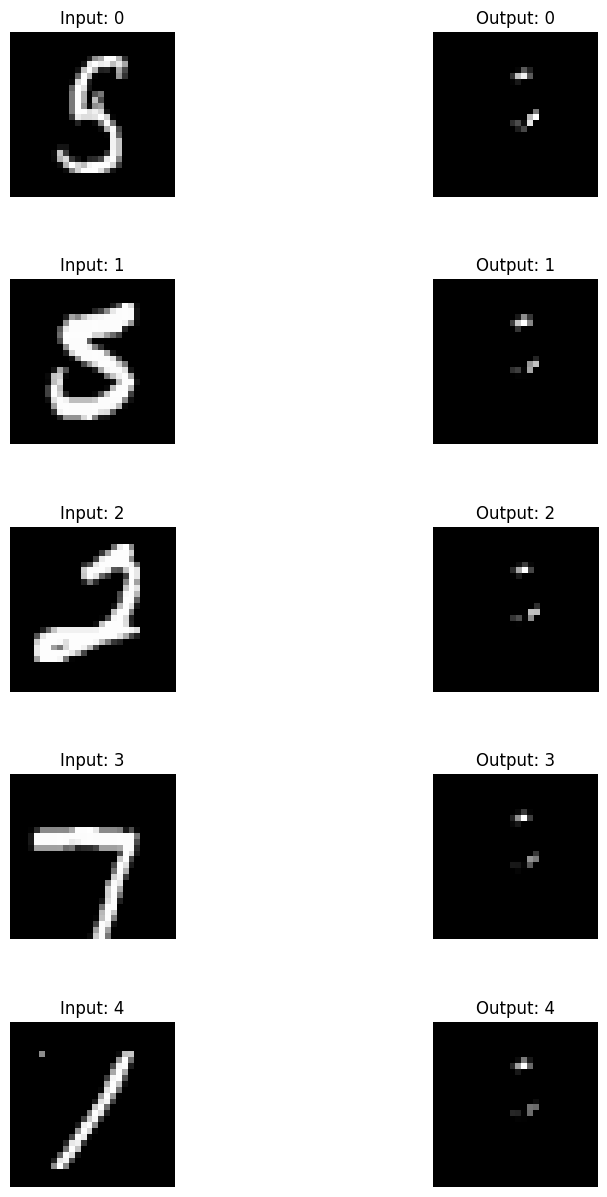

In [11]:
# try to show some images input and output
def show_images_input_output(images, labels, outputs):
    """
    Display a set of input images, their labels, and the corresponding output images.
    """
    # Create a figure with subplots for each image
    fig, axs = plt.subplots(
        ncols=2, nrows=len(images), figsize=(10, 3 * len(images))
    )

    # Loop over the images and display them with their labels
    for i in range(len(images)):
        # Display the input image
        axs[i, 0].imshow(images[i].reshape(28, 28), cmap="gray")
        axs[i, 0].set_title("Input: {}".format(labels[i]))
        axs[i, 0].axis('off')

        # Display the output image
        axs[i, 1].imshow(outputs[i].reshape(28, 28), cmap="gray")
        axs[i, 1].set_title("Output: {}".format(labels[i]))
        axs[i, 1].axis('off')


    # Adjust the spacing between subplots
    fig.subplots_adjust(hspace=0.5)

    # Show the figure
    plt.show()

show_images_input_output(x[5:10], 
                         [str(i) for i in range(10)], 
                         vae_model.forward(x[:10].to(device))[1].cpu().detach().numpy())
# show_images_input_output(x[:10], [str(i) for i in range(10)], model(x[:10])[1].detach().numpy())
   

In [27]:
# print train_x for train_loader
print(train_loader.dataset.data[0])

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   